In [1]:
#define the simulated radition field
from cProfile import label
from mimetypes import init
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from filterpy.kalman import KalmanFilter
from scipy.optimize import minimize

#define a class to hold a radiation field that will be used by other classes
class RadiationField:
  def __init__(self, burst_lat, burst_long, burst_time, altitude):
    self.lat = burst_lat
    self.long = burst_long
    self.time = burst_time
    self.altitude = altitude
  
  def plotField(self):
    raise NotImplementedError("Subclasses must implement plotField method")

  def getDoseRate(self, x, y, time, altitude):
    raise NotImplementedError("Subclasses must implement calculate_intensity method")
  
class GaussianField(RadiationField):
  def __init__(self, burst_lat, burst_long, burst_time=0, altitude=0, sigma=1, decayConstant=1):
    super().__init__(burst_lat, burst_long, burst_time, altitude)
    self.sigma = sigma
    self.decayConstant = decayConstant

  def plotFields(self, time=0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    x, y = np.meshgrid(x, y)
    z = np.exp(-((x**2 + y**2)/(2*self.sigma**2)))
    z = np.exp(-time * self.decayConstant)*z
    ax.plot_surface(x, y, z, cmap='viridis')
    ax.set_xlabel('X') 
    ax.set_ylabel('Y')
    ax.set_zlabel('Intensity')
    ax.set_zlim(0, 1)
    plt.show()

  def plotFields(self, times=[0,1,2]):
    #create a figure with subplots for each time
    fig = plt.figure()
    for t in times:
      ax = fig.add_subplot(1, len(times), t+1, projection='3d')
      x = np.linspace(-10, 10, 100)
      y = np.linspace(-10, 10, 100)
      x, y = np.meshgrid(x, y)
      z = np.exp(-((x**2 + y**2)/(2*self.sigma**2)))
      z = np.exp(-t * self.decayConstant)*z
      ax.plot_surface(x, y, z, cmap='viridis')
      ax.set_xlabel('X') 
      ax.set_ylabel('Y')
      ax.set_zlabel('Intensity')
      ax.set_zlim(0, 1)
      ax.set_title('Time = ' + str(t))
    plt.show()

  def getDoseRate(self, x, y, time, altitude=0):
    #calculate the distance between the burst and the point
    distance = np.sqrt(x**2 + y**2 + altitude**2)
    #calculate the time since the burst
    timeSinceBurst = time - self.time
    #calculate the intensity
    intensity = np.exp(-timeSinceBurst * self.decayConstant) * np.exp(-distance**2 / (2*self.sigma**2))
    return intensity

#define a class to hold a single scattered detector and its related methods
class Detector:
  def __init__(self, id, positionMeasurementNoise=0.2, positionProcessVariance=1e-6, expectedDecayRate=0.1, decayProcessVariance=0.01, nGateways=4):
    self.id = id
    self.predictedDoseRateMeasurements = []
    self.predictedDoseRateUncertainties = []
    self.predictionTimes = []
    self.predictedX = []
    self.predictedY = []
    self.predictedR = 1
    self.posUncertainty = []

    #initialize the kalman filter for estimating the time of flight from each gateway
    self.timeOfFlightFilter = KalmanFilter(dim_x=nGateways, dim_z=nGateways)
    self.timeOfFlightFilter.x = np.zeros(nGateways) #initial state (time of flight to each gateway)
    self.timeOfFlightFilter.F = np.eye(nGateways) #state transition matrix
    self.timeOfFlightFilter.H = np.eye(nGateways) #measurement function
    self.timeOfFlightFilter.R = np.eye(nGateways) * 2 # Measurement noise - this should be near what is expiemntally measured, estimated to be 50 nanoseconds
    self.timeOfFlightFilter.Q = np.eye(nGateways) * 1e-6  # Process noise - static placement, so this is low

    #initialize the kalman filter for estimating the detector position
    self.positionFilter = KalmanFilter(dim_x=4, dim_z=2)
    self.positionFilter.x = np.array([0, 0, 0, 0]) #initial state (x, y, xdot, ydot)
    self.positionFilter.F = np.array([[1, 0, 1, 0], #state transition matrix
                                      [0, 1, 0, 1],
                                      [0, 0, 1, 0],
                                      [0, 0, 0, 1]])
    self.positionFilter.H = np.array([[1, 0, 0, 0], #measurement function
                                      [0, 1, 0, 0]])
    self.positionFilter.R = np.eye(2) * positionMeasurementNoise # Measurement noise - this should be near what is expiemntally measured, estimated to be 200 meters
    self.positionFilter.Q = np.eye(4) * positionProcessVariance  # Process noise - static placement, so this is low

    #initialize the kalman filter for dose rate estimation
    self.doseRateFilter = KalmanFilter(dim_x=2, dim_z=1)
    self.doseRateFilter.x = np.array([0, 1]) #initial state (dose rate and decay rate)
    self.doseRateFilter.F = np.array([[1, 1], [0, 1]]) #state transition matrix
    self.doseRateFilter.H = np.array([[1, 0]]) #measurement function
    self.doseRateFilter.R = np.array([[1e-2]]) #initial measurement noise
    self.doseRateFilter.Q = np.array([[0, 0],[0, decayProcessVariance*expectedDecayRate**2]]) #process noise
  
  def plotDoseRate(self, trueDoseRates):
    #create a figure with subplots for each time
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.errorbar(self.predictionTimes, self.predictedDoseRateMeasurements, yerr=self.predictedDoseRateUncertainties, fmt='o', label='Predicted Dose Rate')
    ax.plot(self.predictionTimes, trueDoseRates, 'r', label='True Dose Rate')
    ax.set_xlabel('Time') 
    ax.set_ylabel('Dose Rate')
    ax.set_title('Dose Rate vs Time')
    ax.legend()
    plt.show()

  def plotDistanceError(self, trueX, trueY):
    #calculate the distance between the true position and the predicted position
    distance = np.sqrt((np.array(self.predictedX) - trueX)**2 + (np.array(self.predictedY) - trueY)**2)
    uncertainty = np.array(self.posUncertainty)
    plt.errorbar(self.predictionTimes, distance*1000, yerr=uncertainty*1000, fmt='o', color='k')
    plt.plot(self.predictionTimes, np.zeros(len(self.predictionTimes)), 'k--')
    plt.xlabel('Time')
    plt.ylabel('Distance from True Position (m)')
    plt.title('Distance from True Position')
    plt.show()

  def update(self, doseMeasurement, doseSigma, differentialToFs, time, gateways):
    #if this is the first measurement, set the initial state to the measurement
    if len(self.predictionTimes) == 0:
      self.positionFilter.x = np.array([0, 0, 0, 0])
      self.doseRateFilter.x = np.array([doseMeasurement, 1])


    self.predictionTimes.append(time)

    #update the dose rate filter
    self.doseRateFilter.R = np.array([[doseSigma]])
    self.doseRateFilter.predict()
    self.doseRateFilter.update(doseMeasurement)
    self.predictedDoseRateMeasurements.append(self.doseRateFilter.x[0])
    self.predictedDoseRateUncertainties.append(np.sqrt(self.doseRateFilter.P[0,0]))

    #update the time of flight filter
    self.timeOfFlightFilter.predict()
    self.timeOfFlightFilter.update(differentialToFs)
    differentialToFs = self.timeOfFlightFilter.x
     
    if len(self.predictedX) == 0:
      initial_guess = [0.0, 0.0, 1]
    else:
      initial_guess = [self.predictedX[-1], self.predictedY[-1], self.predictedR]
    #result = minimize(diffToFerror, initial_guess, args=(differentialToFs, gateways), method='nelder-mead', options={'maxiter': 100})
    result = minimize(diffToFerror, initial_guess, args=(differentialToFs, gateways), method='SLSQP', options={'ftol': 1e-2})

    predictedX, predictedY, self.predictedR = result.x

    #update the position filter
    #use uncertainty in the time of flight to estimate the uncertainty in the position
    self.positionFilter.R = np.eye(2) * np.sqrt(np.sum(self.timeOfFlightFilter.P)) * 0.1
    self.positionFilter.predict()
    self.positionFilter.update(np.array([predictedX, predictedY]))
    self.predictedX.append(self.positionFilter.x[0])
    self.predictedY.append(self.positionFilter.x[1])
    self.posUncertainty.append(np.sqrt(self.positionFilter.P[0,0] + self.positionFilter.P[1,1]))

class SimDetector(Detector):
  def __init__(self, x, y, simRadField, id, positionMeasurementNoise=0.2, positionProcessVariance=1e-6, expectedDecayRate=1, 
               decayProcessVariance=0.1, detMeasurementUncertainty=0.2, minimumNoise=0.2, minimumNoiseUncertainty=0.01, ToFvariance=100):
    super().__init__(id, positionMeasurementNoise, positionProcessVariance, expectedDecayRate, decayProcessVariance)
    self.trueX = x
    self.trueY = y
    self.simRadField = simRadField
    self.minimumNoise = minimumNoise
    self.ToFvariance = ToFvariance
    self.minimumNoiseUncertainty = minimumNoiseUncertainty
    self.trueDoseRates = []
    self.detMeasurementUncertainty = detMeasurementUncertainty
  
  def getTrueDoseRate(self, time):
    return self.simRadField.getDoseRate(self.trueX, self.trueY, time)
  
  def getDoseRateMeasurement(self, time):
    trueDoseRate = self.getTrueDoseRate(time)

    #add noise to the true dose rate
    doseMeasurement = trueDoseRate + np.random.normal(0, trueDoseRate*self.detMeasurementUncertainty ) + self.minimumNoise*np.random.normal(0, self.minimumNoiseUncertainty)
    #ensure the measurement is positive
    if doseMeasurement < 0:
      doseMeasurement = -doseMeasurement
    return doseMeasurement
  
  def getDifferentialTimeOfFlights(self, gateways):
    #calculate the time of flight to each gateway in ns, then add noise
    tofs = []
    for gateway in gateways:
      distance = np.sqrt((self.trueX - gateway.x)**2 + (self.trueY - gateway.y)**2) * 1000 #m
      tof = distance / 299792458 * 1e9 #ns
      tof += np.random.normal(0, self.ToFvariance)
      tofs.append(tof)
    return tofs - np.min(tofs)
  
  def updateSim(self, time, gateways):
    self.trueDoseRates.append(self.getTrueDoseRate(time))
    doseMeasurement = self.getDoseRateMeasurement(time)
    doseSigma = doseMeasurement * self.detMeasurementUncertainty

    #generate time of flight measurements
    dToFs = self.getDifferentialTimeOfFlights(gateways)
    self.update(doseMeasurement, doseSigma, dToFs, time, gateways)

class Gateway:
  def __init__(self, x, y):
    self.x = x
    self.y = y

def diffToFerror(vars, dTof, gateways):
    x, y, r = vars
    totalError = 0
    for tof, gateway in zip(dTof, gateways):
        tof *= 1e-9  # Convert from ns to s
        error = (r + tof * 299792458/1000)**2 - (x - gateway.x)**2 - (y - gateway.y)**2
        totalError += error**2
    return totalError

def minimumRadius(r, c, dtofs, gateways):
    result = 0
    for tof, gateway in zip(dtofs, gateways):
        result += (r + tof * c)**2 - (gateways[0].x - gateway.x)**2 - (gateways[0].y - gateway.y)**2
    return result

def metersToDeltaLat(meters):
  return meters / 111111

def metersToDeltaLong(meters, lat):
  return np.abs(meters / (111111 * np.cos(lat)))

def deltaLatToMeters(deltaLat):
  return deltaLat * 111111

def deltaLongToMeters(deltaLong, lat):
  return np.abs(deltaLong * 111111 * np.cos(lat))

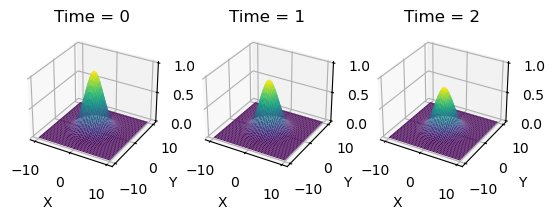

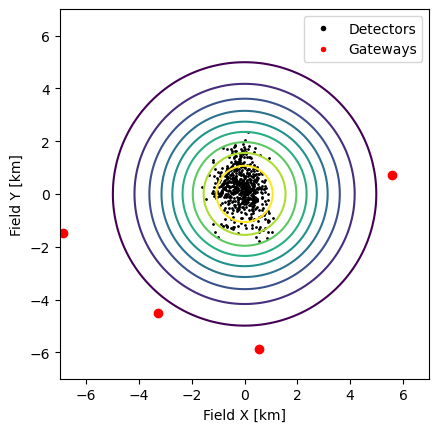

In [2]:
## run a simulation

#lat/long for omaha, NE
#lat = 41.2565
#long = 95.9345

from multiprocessing import Pool
from multiprocessing import cpu_count

from torch import ge

gz_lat = 41.2565
gz_long = 95.9345

artyDistrobutionWidth = 2 #kilometers
detectorDistrobutionWidth = .3 #kilometers
lsDistFromGZ = 6 #kilometers
nArtyShells = 20
nDetectorsPerShell = 30
timesteps = 100

def plotSim(detectors, gateways, gaussianField):
  gaussianField.plotFields()

  #plot the initial positions of the detectors
  fig = plt.figure()
  ax = fig.add_subplot(111)
  for detector in detectors:
    #plot each detector as a small black circle
    ax.plot(detector.trueX, detector.trueY, 'o', c='k', markersize=1)

  #plot the gateways
  for gateway in gateways:
    ax.plot(gateway.x, gateway.y, 'o', c='r')

  ax.set_xlim(-lsDistFromGZ-1, lsDistFromGZ+1)
  ax.set_ylim(-lsDistFromGZ-1, lsDistFromGZ+1)

  #plot the countours of the radiation field at the time of the burst
  #draw lines for the following levels: 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9
  x = np.linspace(-lsDistFromGZ-1, lsDistFromGZ+1, 100)
  y = np.linspace(-lsDistFromGZ-1, lsDistFromGZ+1, 100)
  x, y = np.meshgrid(x, y)
  z = np.zeros(x.shape)
  for i in range(x.shape[0]):
    for j in range(x.shape[1]):
      z[i,j] = gaussianField.getDoseRate(y[i,j], x[i,j], 0)
  contours = plt.contour(x, y, z, levels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

  #add a legend
  handles = [
      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=5),
      plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=5)
  ]
  labels = ['Detectors', 'Gateways']
  ax.legend(handles, labels)

  #dress it up
  ax.set_xlabel('Field X [km]')
  ax.set_ylabel('Field Y [km]')
  ax.set_aspect('equal')

  plt.show()

def updateDetector(detector, gateways):
  for t in range(timesteps):
    detector.updateSim(t, gateways)
  return detector

def runSim():
  sigma = np.random.uniform(1, 3)
  decayConstant = np.random.uniform(0.1, 0.2)
  gaussianField = GaussianField(burst_lat=gz_lat, burst_long=gz_long, sigma=sigma, decayConstant=decayConstant)

  #initialize the detectors
  detectors = []

  for i in range(nArtyShells):
    r = np.random.uniform(0, artyDistrobutionWidth)*np.sqrt(np.random.uniform(0, 1))
    theta = np.random.uniform(0, 2*np.pi)

    x = r * np.sin(theta)
    y = r * np.cos(theta)

    for j in range(nDetectorsPerShell):
      detX = x + np.random.normal(0, detectorDistrobutionWidth)
      detY = y + np.random.normal(0, detectorDistrobutionWidth)

      detector = SimDetector(x=detX, y=detY, simRadField=gaussianField, id=i*nDetectorsPerShell+j)
      detectors.append(detector)

  gateways = []
  angles = []
  #determine 4 random angles and then use those to determine the gateway positions lsDistFromGZ away from ground zero
  for i in range(4):
    angle = np.random.uniform(0, 2*np.pi)
    #ensure the angles are at least 30 degrees apart and that they are within a 180 degree arc
    while len(angles) > 0 and (np.min(np.abs(np.array(angles) - angle)) < np.pi/6 or np.max(np.abs(np.array(angles) - angle)) > np.pi):
      angle = np.random.uniform(0, 2*np.pi)
    angles.append(angle)
    gatewayX = (lsDistFromGZ+np.random.normal(0, 0.5)) * np.sin(angle)
    gatewayY = (lsDistFromGZ+np.random.normal(0, 0.5)) * np.cos(angle)
    gateways.append(Gateway(gatewayX, gatewayY))

  pool = Pool(cpu_count())
  detectors = pool.starmap(updateDetector,  [(detector, gateways) for detector in detectors])
  pool.close()
  pool.join()

  return detectors, gateways, gaussianField

#if main, run the simulation
if __name__ == '__main__':
  detectors, gateways, gaussianField = runSim()
  plotSim(detectors, gateways, gaussianField)

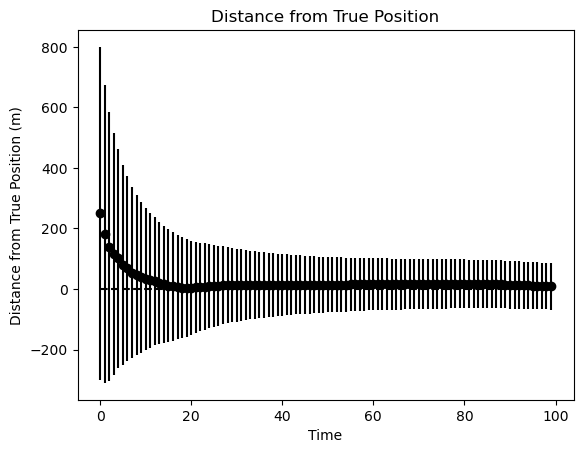

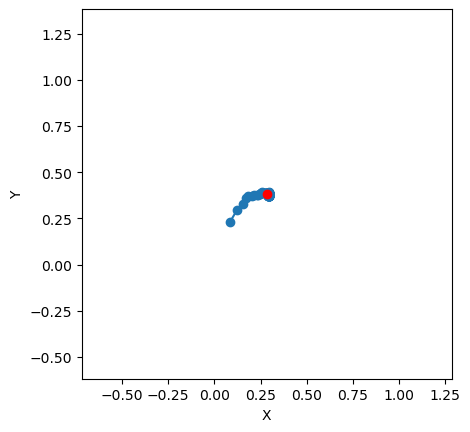

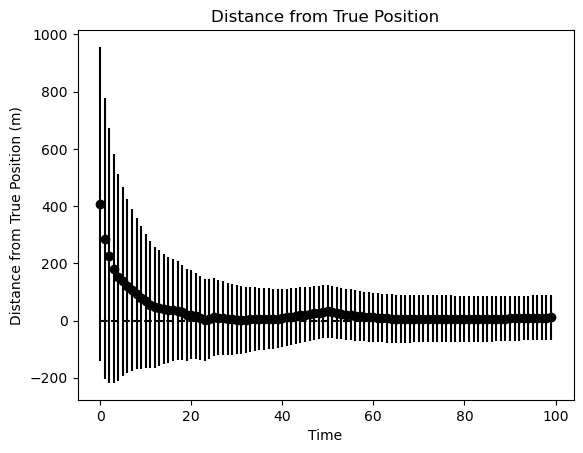

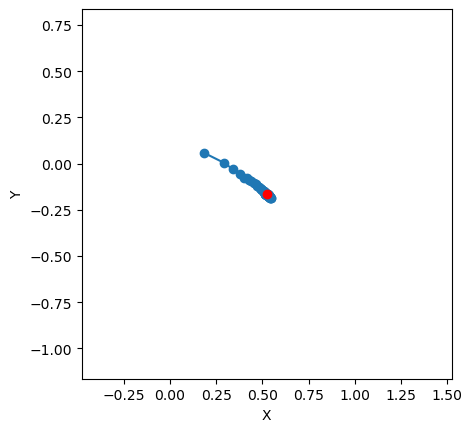

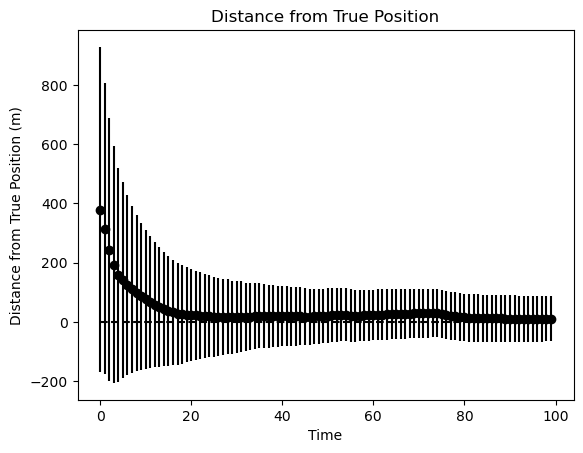

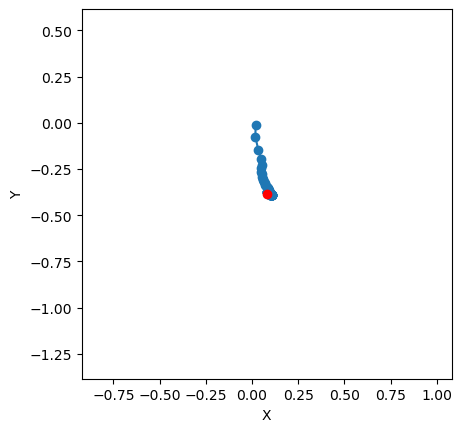

In [28]:
## confirm the results by plotting the dose rate and position estimates for a single detector

for det in detectors[:3]:
    #plot the dose rate and position estimates for a single detector
    det.plotDistanceError(det.trueX, det.trueY)
    
    #plot the series of predicted positions for a single detector
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(det.predictedX, det.predictedY, 'o-')
    ax.plot(det.trueX, det.trueY, 'ro')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(det.trueX-1, det.trueX+1)
    ax.set_ylim(det.trueY-1, det.trueY+1)
    ax.set_aspect('equal')
    plt.show()

In [4]:
## prepare the data for a pyTorch GRU model if only one sim is run
detectors, gateways, gaussianField = runSim()

#determine the number of timesteps in the simulated data
nTimesteps = len(detectors[0].predictedDoseRateMeasurements)

#determine the number of detectors in the simulated data
nDetectors = len(detectors)

#the detector data needs to be restructed for a pyTorch GRU model
#the data needs to be in the form [nTimesteps, nDetectors, nFeatures]
#the features will be the dose rate, dose rate uncertainty, the x and y position, and the position uncertainty
#initialize the data array
data = np.zeros((nTimesteps, nDetectors, 5))
#fill the data array
for i, detector in enumerate(detectors):
  data[:,i,0] = detector.predictedDoseRateMeasurements
  data[:,i,1] = detector.predictedDoseRateUncertainties
  data[:,i,2] = detector.predictedX
  data[:,i,3] = detector.predictedY
  data[:,i,4] = detector.posUncertainty

In [79]:
import pickle
from tqdm import tqdm

## prepare the data for a pyTorch GRU model for batch training
totalSims = 64
mapSize = 256

#initialize the data array
detData = np.zeros((totalSims, timesteps, nArtyShells*nDetectorsPerShell, 5))
doseRateData = np.zeros((totalSims, timesteps, mapSize, mapSize))

#define a temp meshgrid for the dose rate data
x = np.linspace(-lsDistFromGZ-1, lsDistFromGZ+1, mapSize)
y = np.linspace(-lsDistFromGZ-1, lsDistFromGZ+1, mapSize)
x, y = np.meshgrid(x, y)

for i in tqdm(range(totalSims)):
    detectors, gateways, gaussianField = runSim()

    #fill the detData array
    for j, detector in enumerate(detectors):
        detData[i,:,j,0] = detector.predictedDoseRateMeasurements
        detData[i,:,j,1] = detector.predictedDoseRateUncertainties
        detData[i,:,j,2] = detector.predictedX
        detData[i,:,j,3] = detector.predictedY
        detData[i,:,j,4] = detector.posUncertainty

    #for each timestep, calculate the dose rate at each point on the map
    for t in range(timesteps):
        doseRateData[i,t,:,:] = gaussianField.getDoseRate(y, x, t)

print('saving data')
#save the numpy detData array
with open('./detData.npy', 'wb') as f:
    np.save(f, detData)
#save the numpy detData array
with open('./doseRateData.npy', 'wb') as f:
    np.save(f, doseRateData)



100%|██████████| 64/64 [05:24<00:00,  5.07s/it]


saving data


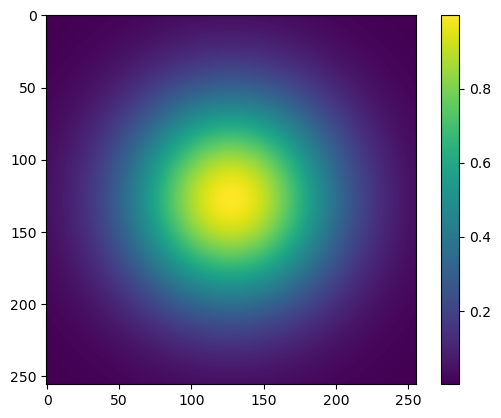

In [80]:
# plot the first dose rate map of the first simulation
plt.imshow(doseRateData[0,0,:,:])
plt.colorbar()
plt.show()

In [81]:
#load saved data
with open('./detData.npy', 'rb') as f:
    detData = np.load(f)

with open('./doseRateData.npy', 'rb') as f:
    doseRateData = np.load(f)

In [82]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batchSize = 32

def rotateDetectors(data):
    # Rotate the detectors x, y positions a random amount about the origin
    batch_size, num_time_steps, num_detectors, _ = data.shape
    theta = torch.empty(batch_size, 1, 1, 1).uniform_(0, 2 * torch.pi)  # Generate random angles for each batch
    
    # Extract x and y positions
    x = data[:, :, :, 2].unsqueeze(-1)
    y = data[:, :, :, 3].unsqueeze(-1)

    # Compute rotated x and y positions
    rotated_x = x * torch.cos(theta) - y * torch.sin(theta)
    rotated_y = x * torch.sin(theta) + y * torch.cos(theta)

    # Assign rotated x and y positions back to the data tensor
    data[:, :, :, 2] = rotated_x.squeeze(-1)
    data[:, :, :, 3] = rotated_y.squeeze(-1)

    return data


# Custom DataLoader class
class CustomDataLoader(DataLoader):
    def __init__(self, detData, doseRateData, batch_size=32, shuffle=True):
        self.detData = detData
        self.doseRateData = doseRateData
        super().__init__(TensorDataset(detData, doseRateData), batch_size=batch_size, shuffle=shuffle)

    def __iter__(self):
        for batch in super().__iter__():
            rotatedDetectors = rotateDetectors(batch[0])  # Manipulate detData in each batch
            yield (rotatedDetectors, batch[1])  # Yield manipulated batch

#convert the data to a tensor
detData_tensor = torch.tensor(detData, dtype=torch.float32)
doseRateData_tensor = torch.tensor(doseRateData, dtype=torch.float32)

#initialize the data loader
dataLoader = CustomDataLoader(detData_tensor, doseRateData_tensor, batch_size=batchSize, shuffle=True)

In [87]:
#test the loader
for batch in dataLoader:
    print(batch[0].shape, batch[1].shape)
    break

torch.Size([32, 100, 600, 5]) torch.Size([32, 100, 256, 256])


In [95]:
from math import comb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GRU(nn.Module):
    def __init__(self, nSensors, nFeaturesPerSensor, hidden_size=16):
        super(GRU, self).__init__()
        self.nSensors = nSensors
        self.nFeaturesPerSensor = nFeaturesPerSensor
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=nFeaturesPerSensor, hidden_size=hidden_size, batch_first=True)
    
    def forward(self, x):
        batchSize, nTimeStep, _, _ = x.size()
        # Reshape input to merge nSensors dimension with batch dimension
        x = x.view(batchSize * nTimeStep, self.nSensors, self.nFeaturesPerSensor)
        
        # Pass through GRU
        out, _ = self.gru(x)
        
        # Reshape output to original shape
        out = out.view(batchSize, nTimeStep, -1)
        
        return out
    

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        #create a fully connected layer to map the gru output to the dose rate map
        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 256*256)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #map the gru output to the dose rate map
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = x.view(-1, 256, 256)
        return x

# Hyperparameters for the gru model
nTimesteps = data.shape[1]
nDetectors = data.shape[2]
nDetFeatures = data.shape[3]
gruHiddenSize = 64 #this is arbitrary, but the more complex the data, the larger this should be
gruLayers = 2 #this is arbitrary, but the larger this is, the more the model remembers from the past
gruOutputSize = 16 #this is the latent space for the field recontruction

#TODO: add a weather compression model
weatherOutputSize = 8

#TODO: add a terrain compression model
terrainOutputSize = 8

#initialize the model
gru = GRU(nDetectors, nDetFeatures, gruHiddenSize).to(device)
#predictDoseRateMap = Decoder().to(device)




In [97]:
#test a forward pass
detData = data[:batchSize].reshape(batchSize, nTimesteps, nDetectors, nDetFeatures)
x = torch.from_numpy(detData).float().to(device)
doseLatentSpace = gru(x)

print(doseLatentSpace.shape)

weatherLatentSpace = torch.zeros(batchSize, weatherOutputSize).to(device)
terrainLatentSpace = torch.zeros(batchSize, terrainOutputSize).to(device)

#combine the latent spaces
combinedLatentSpace = torch.cat((doseLatentSpace, weatherLatentSpace, terrainLatentSpace), 1)


#conduct the forward pass
#doseRateMap = predictDoseRateMap(combinedLatentSpace)

#print the number of parameters in the model
#summary(gru, input_size=(batchSize, nTimesteps, gruInputSize))
#summary(predMap, input_size=(batchSize, gruOutputSize))

#plot the dose rate map
#plt.imshow(doseRateMap[0].detach().cpu().numpy(), cmap='viridis')
#plt.title('Predicted Dose Rate Map - pre-training')
#plt.colorbar()
#plt.show()

OutOfMemoryError: CUDA out of memory. Tried to allocate 7.33 GiB. GPU 0 has a total capacity of 11.72 GiB of which 2.67 GiB is free. Including non-PyTorch memory, this process has 6.83 GiB memory in use. Of the allocated memory 2.65 GiB is allocated by PyTorch, and 4.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [90]:
#prepare for training the model
#initialize the loss function and optimizer
criterion = nn.MSELoss()
gruOptimizer = torch.optim.Adam(gru.parameters(), lr=0.001)
predMapOptimizer = torch.optim.Adam(predictDoseRateMap.parameters(), lr=0.001)

#initialize the number of epochs
nEpochs = 10

#initialize the loss array
losses = []

In [91]:
#train the model

for epoch in range(nEpochs):
    for i, (detData, doseRateData) in enumerate(dataLoader):
        detData = detData.to(device)
        doseRateData = doseRateData.to(device)

        # Forward pass
        doseLatentSpace = gru(detData.reshape(batchSize, nTimesteps, gruInputSize))
        weatherLatentSpace = torch.zeros(batchSize, weatherOutputSize).to(device)
        terrainLatentSpace = torch.zeros(batchSize, terrainOutputSize).to(device)

        #combine the latent spaces
        combinedLatentSpace = torch.cat((doseLatentSpace, weatherLatentSpace, terrainLatentSpace), 1)

        #conduct the forward pass
        doseRateMap = predictDoseRateMap(combinedLatentSpace)

        print(doseRateMap.shape)
        print(doseRateData.shape)

        #calculate the loss
        loss = criterion(doseRateMap, doseRateData)

        # Backward pass and optimize
        gruOptimizer.zero_grad()
        predMapOptimizer.zero_grad()
        loss.backward()
        gruOptimizer.step()
        predMapOptimizer.step()

        #store the loss
        losses.append(loss.item())

        if (i+1) % 10 == 0:
            print (f'Epoch [{epoch+1}/{nEpochs}], Step [{i+1}/{len(dataLoader)}], Loss: {loss.item():.4f}')

torch.Size([32, 256, 256])
torch.Size([32, 100, 256, 256])


RuntimeError: The size of tensor a (32) must match the size of tensor b (100) at non-singleton dimension 1